# Проект: классификация

In [707]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [708]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [709]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [710]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [711]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def bal_clean(x):
    try:
        bc = x[:-2].replace(',', '.').replace(' ', '')
    except TypeError:
        bc = x
    return bc

df['balance'] = df['balance'].apply(bal_clean)
df['balance'] = df['balance'].astype(float)
df['balance'].mean()

1529.1290293615875

### Задание 4

In [712]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
df.info()
df['balance'].mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


1526.9360329690019

### Задание 5

In [713]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
new_job = df.job.mode()
new_edu = df.education.mode()
for i in df.index:
    if df.loc[i, 'job'] == 'unknown':
        df.loc[i, 'job'] = new_job[0]
    if df.loc[i, 'education'] == 'unknown':
        df.loc[i, 'education'] = new_edu[0]
display(df['job'].unique())
display(df['education'].unique())

df[(df.job == new_job[0])&(df.education == new_edu[0])].balance.mean()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

array(['secondary', 'tertiary', 'primary'], dtype=object)

1598.8829787234042

### Задание 6

In [714]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    print(lower_bound)
    upper_bound = quartile_3 + (iqr * 1.5)
    print(upper_bound)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

-2241.0
4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

<Axes: >

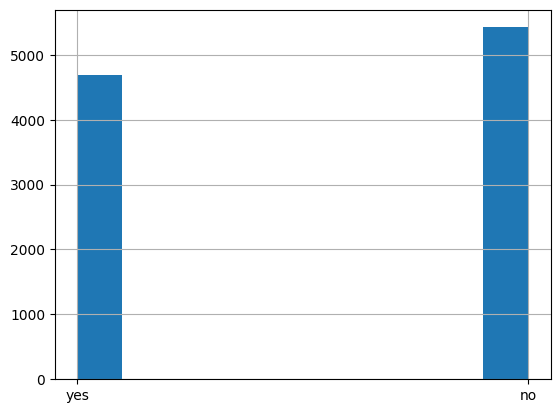

In [715]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(cleaned.deposit.value_counts())
cleaned.deposit.hist()

### Задания 2 и 3

In [716]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1526.936033,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3224.829691,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,123.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1699.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### Задания 4 и 5

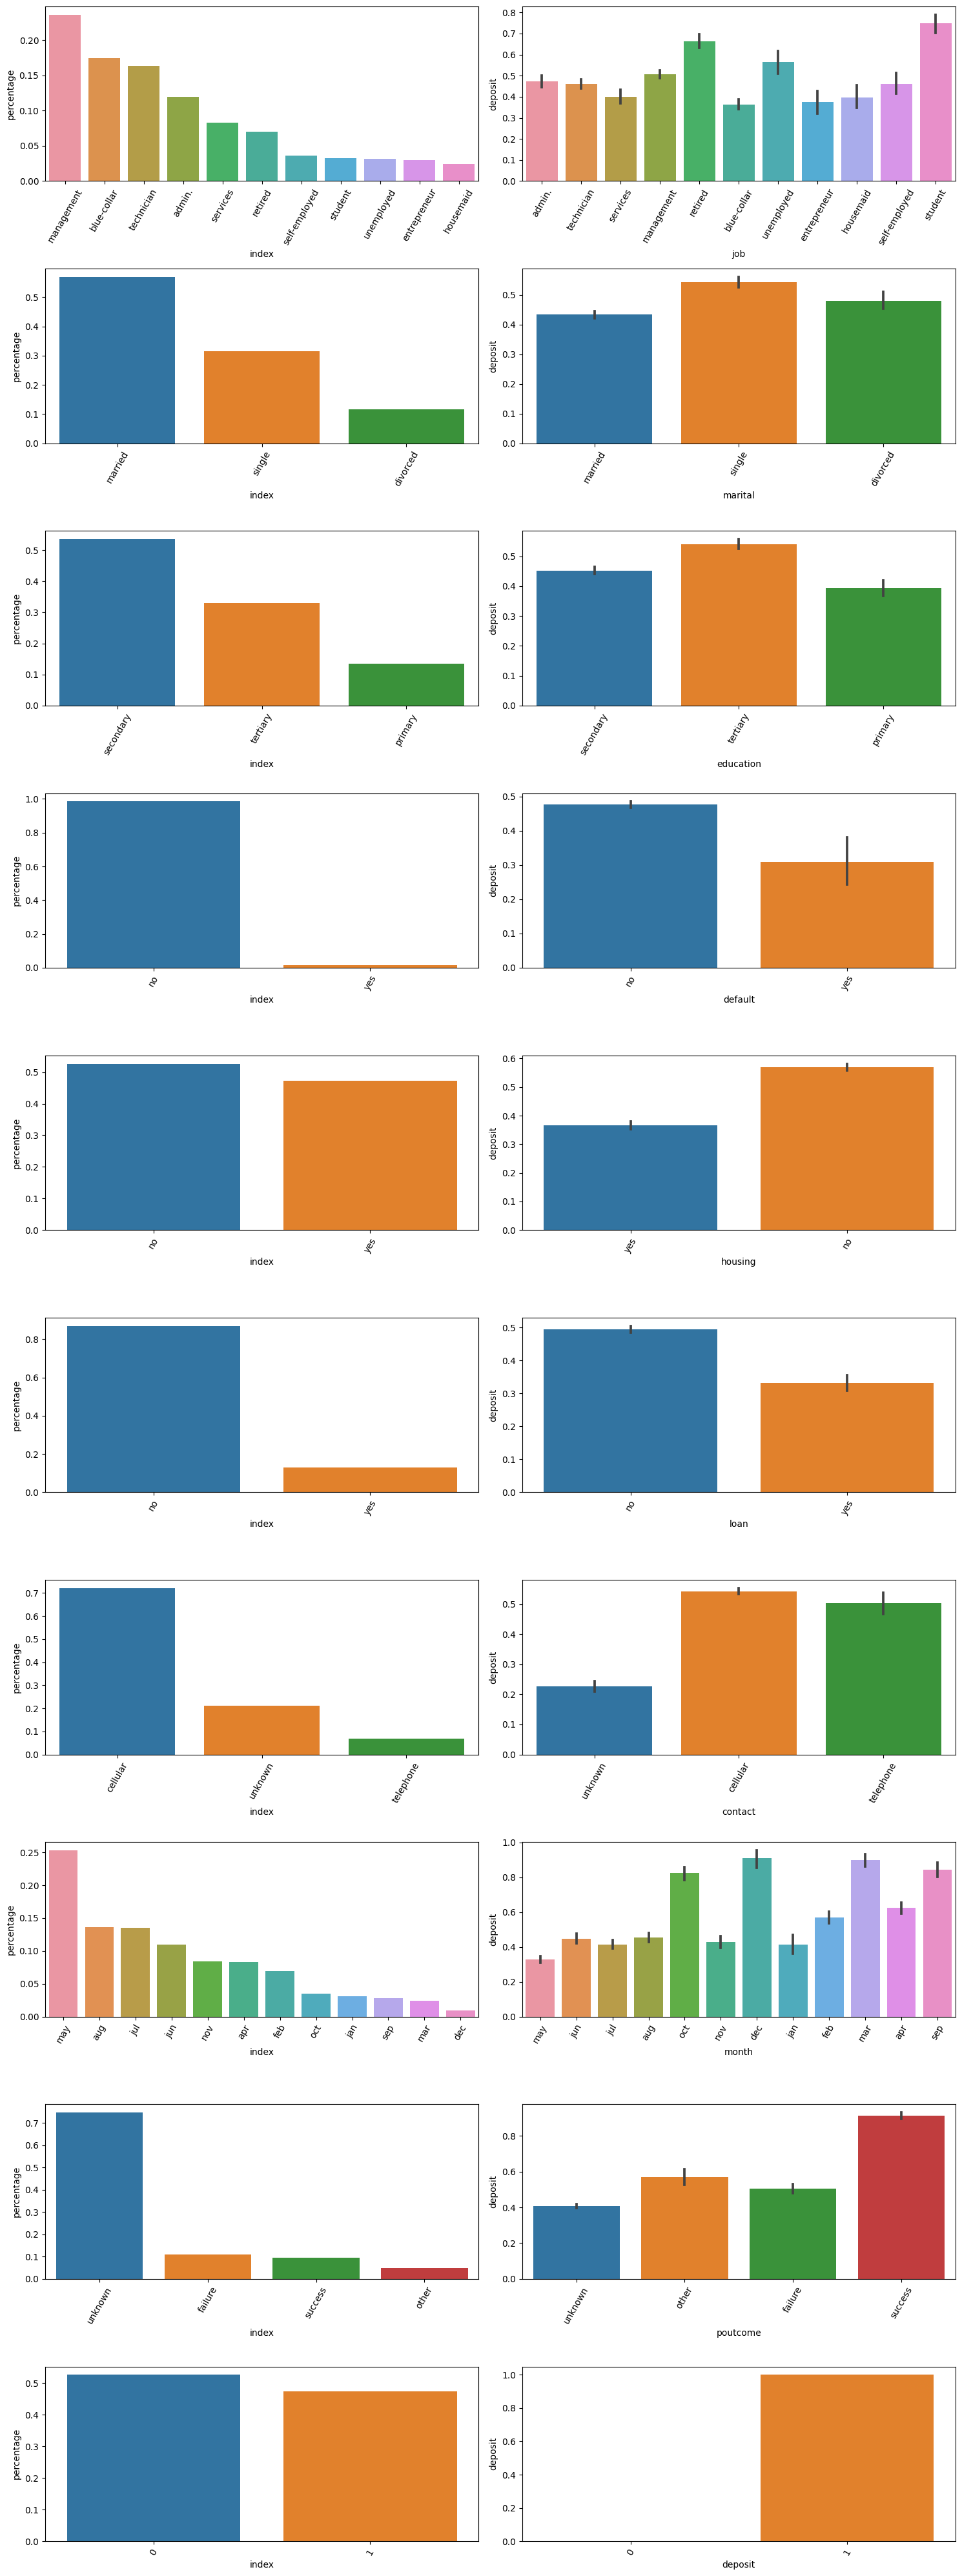

In [717]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout()
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [718]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
display(df[['poutcome', 'deposit']].value_counts())

poutcome  deposit
unknown   0          4940
          1          3386
success   1           978
failure   1           618
          0           610
other     1           307
          0           230
success   0            93
dtype: int64

### Задание 7

In [719]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
for m in list(set(df.month.to_list())):
    print(m, df[(df['month']==m) & (df['deposit']==0)]['deposit'].count()/df[(df['month']==m) & (df['deposit']==1)]['deposit'].count())#/df[df['month'==m, 'deposit'==1]].count())


oct 0.21362229102167182
jun 1.2380952380952381
apr 0.5996533795493935
feb 0.7596371882086168
nov 1.3399503722084367
may 2.052972972972973
jul 1.4146730462519936
jan 1.4225352112676057
sep 0.18587360594795538
dec 0.1
aug 1.2078488372093024
mar 0.11290322580645161


### Задание 8

In [720]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_set(x):
    if x < 30:
        return "<30"
    elif x < 40:
        return "30-40"
    elif x < 50:
        return "40-50"
    elif x < 60:
        return "50-60"
    else:
        return '60+'

df['age_cat'] = df['age'].apply(age_set)

<Axes: xlabel='age_cat', ylabel='Count'>

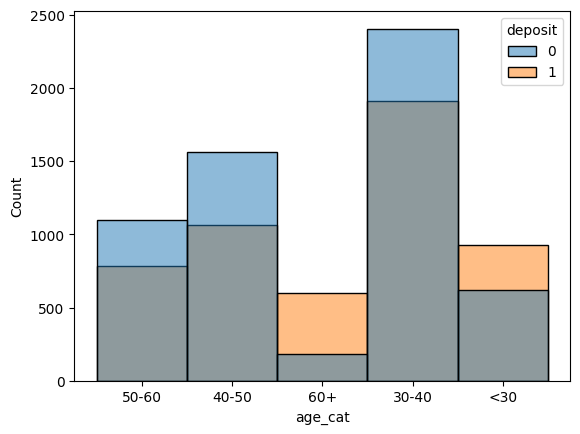

In [721]:
import seaborn as sns
sns.histplot(x='age_cat', hue='deposit', data=df)

### Задания 9 и 10

<Axes: xlabel='marital', ylabel='Count'>

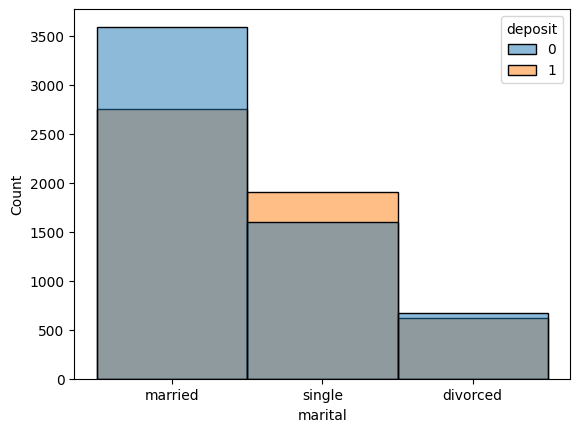

In [722]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.histplot(x='marital', hue='deposit', data=df)

<Axes: xlabel='education', ylabel='Count'>

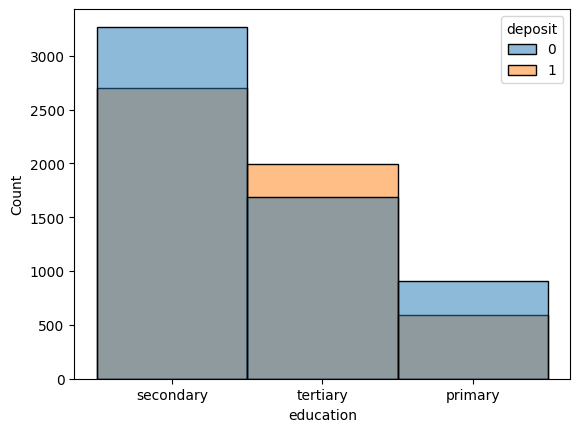

In [723]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.histplot(x='education', hue='deposit', data=df)

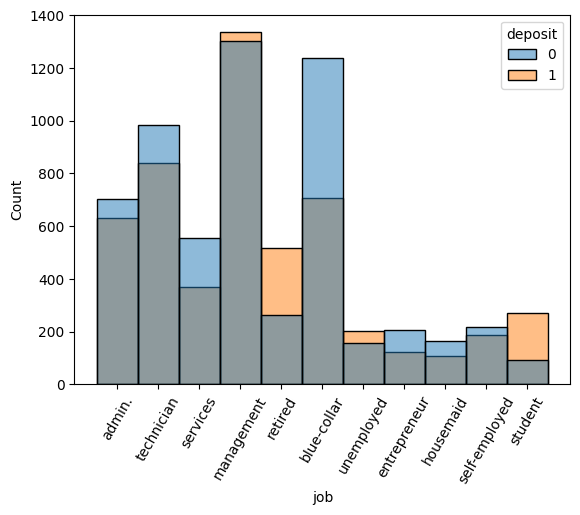

In [724]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt_1 = sns.histplot(x='job', hue='deposit', data=df)
plt_1.xaxis.set_tick_params(rotation=60)

### Задание 11

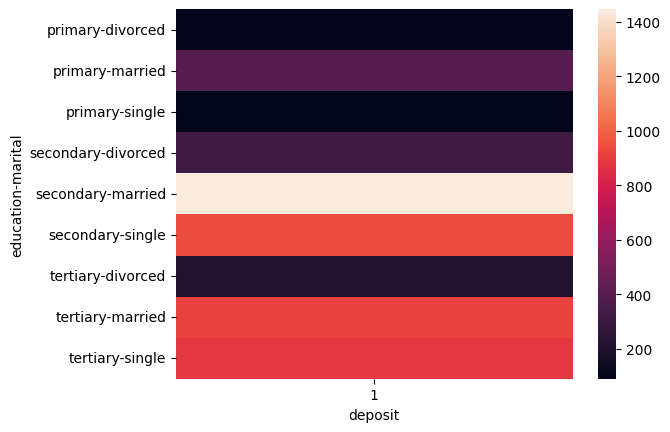

In [725]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

p1 = df[df['deposit']==1]
p1 = pd.DataFrame(p1.pivot_table(
    values='day',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))
fig = sns.heatmap(
    data=p1, #DataFrame
)


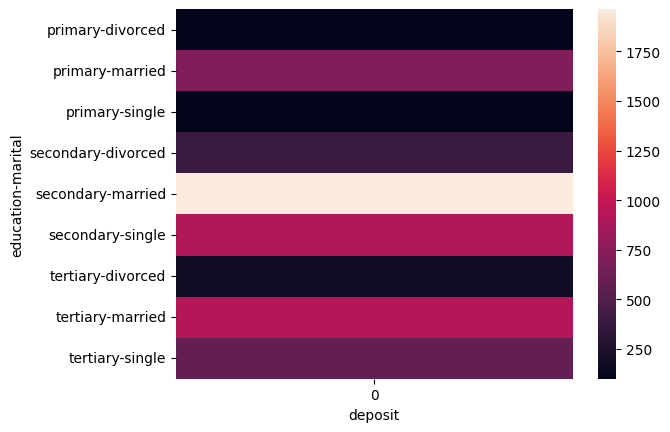

In [726]:
p2 = df[df['deposit']==0]
p2 = pd.DataFrame(p2.pivot_table(
    values='age',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))
fig = sns.heatmap(
    data=p2, #DataFrame
)

## Часть 3: преобразование данных

### Задание 1

In [727]:
# преобразуйте уровни образования
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
type_le = le.fit_transform(cleaned['education'])
# df = pd.concat([df, type_le], axis=1)
display(type_le)
cleaned['education'] = type_le
display(cleaned['education'].sum())

def age_set(x):
    if x < 30:
        return "<30"
    elif x < 40:
        return "30-40"
    elif x < 50:
        return "40-50"
    elif x < 60:
        return "50-60"
    else:
        return '60+'

cleaned['age'] = cleaned['age'].apply(age_set)
type_le = le.fit_transform(cleaned['age'])
cleaned['age'] = type_le
cleaned['age']


array([1, 1, 1, ..., 1, 1, 1])

11995

0        2
1        2
2        1
3        2
4        2
        ..
11157    0
11158    0
11159    0
11160    1
11161    0
Name: age, Length: 10105, dtype: int32

### Задания 2 и 3

In [728]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned.deposit = cleaned.deposit.apply(lambda x: 1 if x=="yes" else 0)
cleaned.default = cleaned.default.apply(lambda x: 1 if x=="yes" else 0)
cleaned.housing = cleaned.housing.apply(lambda x: 1 if x=="yes" else 0)
cleaned.loan = cleaned.loan.apply(lambda x: 1 if x=="yes" else 0)
cleaned.deposit.std()
print(cleaned.default.mean() + cleaned.housing.mean() + cleaned.loan.mean() )

0.6354280059376547


### Задание 4

In [729]:
# создайте дамми-переменные
categorical_columns_names = ['job', 'marital', 'contact', 'month', 'poutcome']
encoded_columns = pd.get_dummies(cleaned, columns = categorical_columns_names)
encoded_columns

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,2,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,1,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,2,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,2,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,0,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,0,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,1,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


### Задания 5 и 6

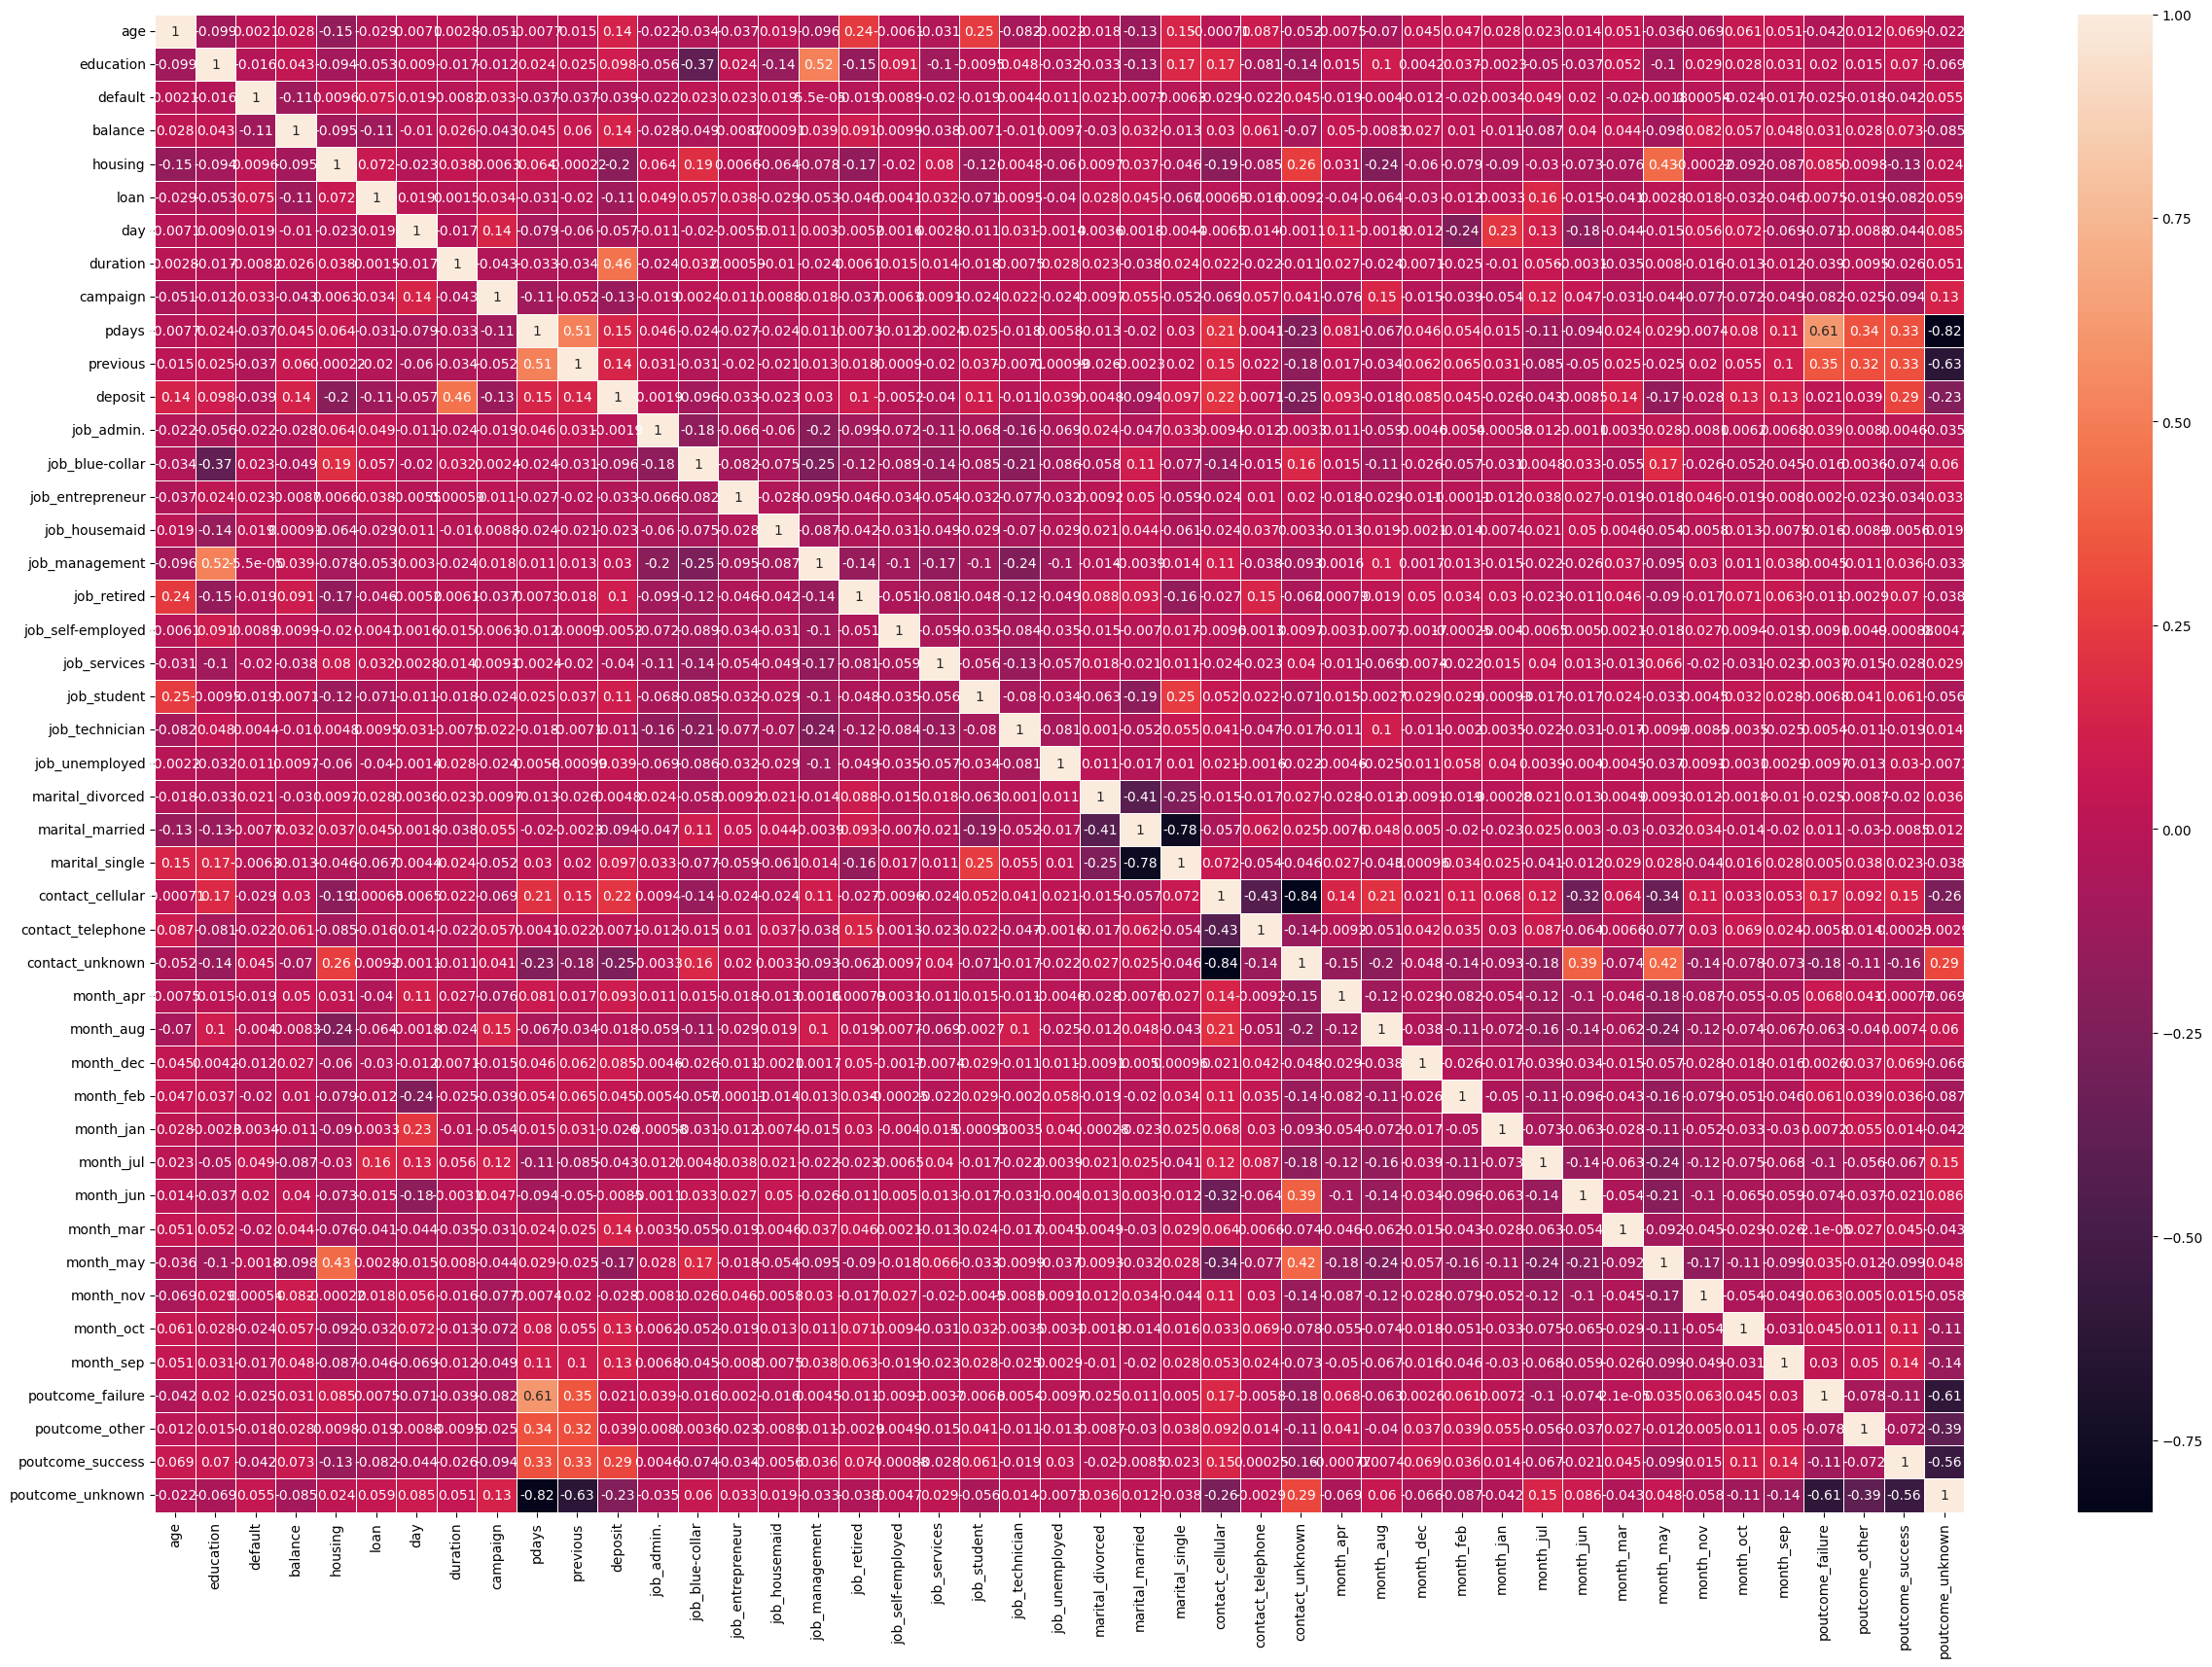

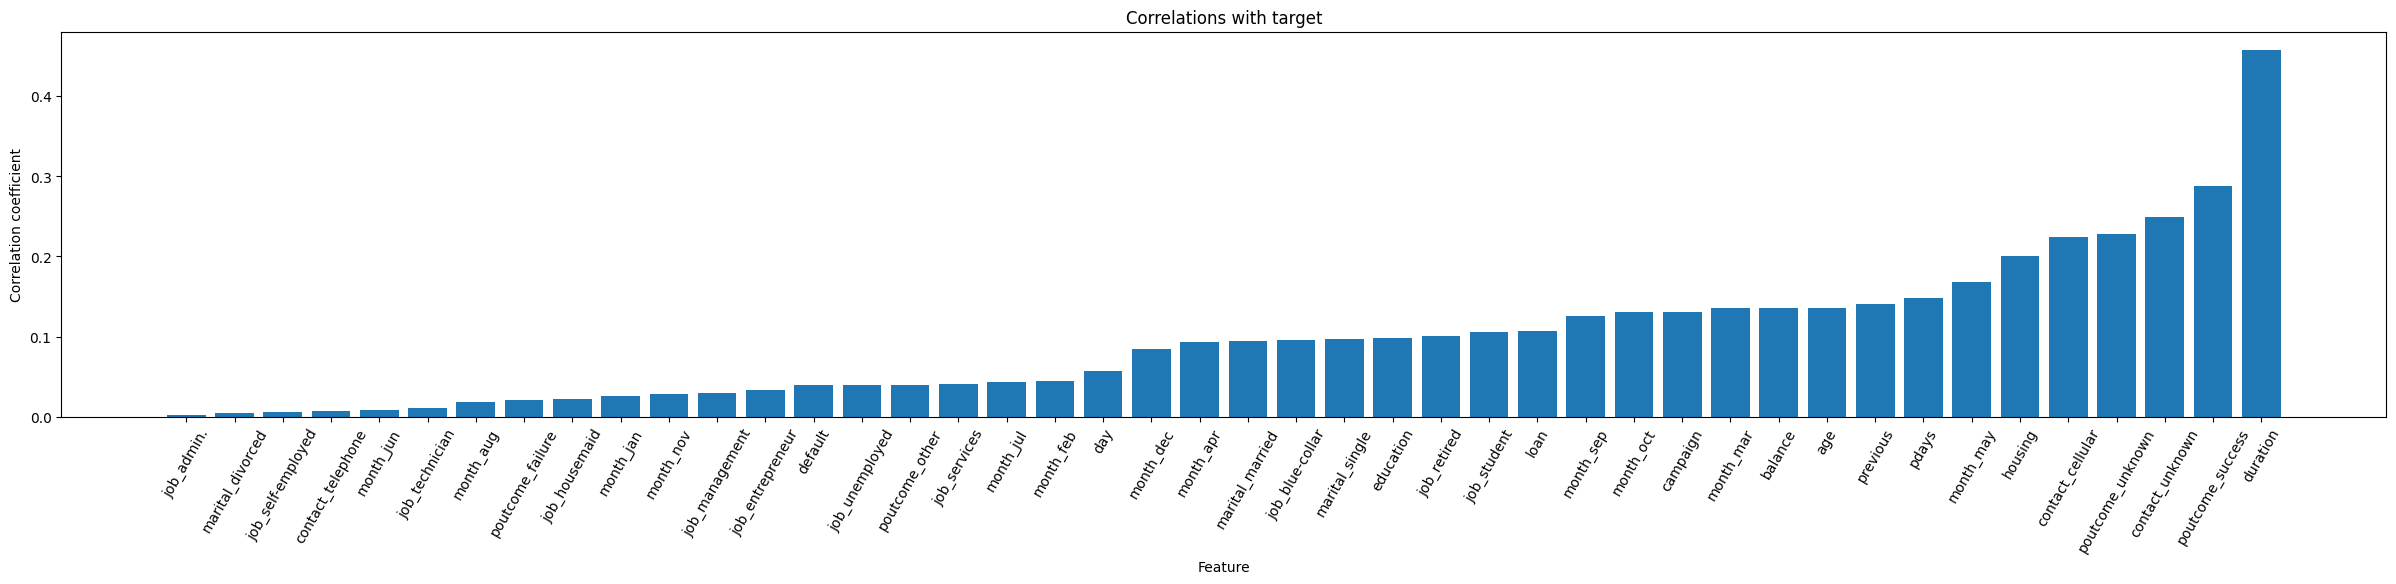

In [730]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(encoded_columns.corr(numeric_only='True'), annot=True, linewidths=.5, ax=ax)

#Вычисляем модуль корреляции
corr_with_target = encoded_columns.corr()['deposit'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('deposit')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(30, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y
ax.xaxis.set_tick_params(rotation=60)

### Задания 7 и 8

In [731]:
X = encoded_columns.drop(['deposit'], axis=1)
y = encoded_columns['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [732]:
# рассчитайте необходимые показатели
X_test.shape
y_test.mean()

0.46326836581709147

### Задание 9

In [733]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()
# X_train = X_train[a]
# X_test = X_test[a]

array(['age', 'balance', 'housing', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [734]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

list_x_test= []
for i in range(0, len(X_test_scaled)):
    list_x_test.append(X_test_scaled[i][3])
sum(list_x_test)/len(list_x_test)

0.46823674223097655

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [735]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
log_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_test_pred = log_model.predict(X_test_scaled)
y_train_pred = log_model.predict(X_train_scaled)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.82      0.82      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      3634
           1       0.85      0.80      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770



### Задания 2,3,4

In [736]:
# обучите решающие деревья, настройте максимальную глубину
tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy')
tree_model.fit(X_train_scaled, y_train)
y_test_pred = tree_model.predict(X_test_scaled)
y_train_pred = tree_model.predict(X_train_scaled)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.79      0.80      0.79      1790
           1       0.76      0.75      0.76      1545

    accuracy                           0.78      3335
   macro avg       0.78      0.78      0.78      3335
weighted avg       0.78      0.78      0.78      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



### Задание 5

In [737]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7],
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy',max_depth=6, min_samples_split=2)
tree_model.fit(X_train_scaled, y_train)
y_test_pred = tree_model.predict(X_test_scaled)
y_train_pred = tree_model.predict(X_train_scaled)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')



CPU times: total: 78.1 ms
Wall time: 403 ms
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}
Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.80      3335
weighted avg       0.81      0.81      0.81      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      3634
           1       0.78      0.86      0.82      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [738]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10 ,random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Train: 0.87
Test: 0.83
Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770



### Задания 2 и 3

In [739]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
gb = GradientBoostingClassifier(
    # loss='deviance', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    min_samples_leaf=5,
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки

y_train_pred = gb.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = gb.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Train: 0.91
Test: 0.85
Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.87      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.93      0.90      0.92      3634
           1       0.89      0.92      0.91      3136

    accuracy                           0.91      6770
   macro avg       0.91      0.91      0.91      6770
weighted avg       0.91      0.91      0.91      6770



### Задание 4

In [745]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

estimators = [
    ('tr', tree_model),
    ('gc', gb)
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=log_model
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test_scaled)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack), 2)}')
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_pred_stack)}')

Качество предсказания по MSE для стекинга 0.15
Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.83      0.87      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.86      0.85      3335
weighted avg       0.86      0.85      0.85      3335



### Задание 5

In [746]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [747]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
random_state=42

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score


In [748]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-04-13 17:45:21,391] A new study created in memory with name: RandomForestClassifier
[I 2023-04-13 17:45:22,574] Trial 0 finished with value: 0.8856832635334264 and parameters: {'n_estimators': 112, 'max_depth': 14, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8856832635334264.
[I 2023-04-13 17:45:23,555] Trial 1 finished with value: 0.9401094605160282 and parameters: {'n_estimators': 139, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9401094605160282.
[I 2023-04-13 17:45:24,229] Trial 2 finished with value: 0.8830445544554456 and parameters: {'n_estimators': 115, 'max_depth': 29, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.9401094605160282.
[I 2023-04-13 17:45:25,240] Trial 3 finished with value: 0.866387985756309 and parameters: {'n_estimators': 187, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.9401094605160282.
[I 2023-04-13 17:45:25,890] Trial 4 finished with value: 0.8770136307311028 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 162, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.95


In [749]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.85


In [750]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]

#calculate RMSE
sqrt(mean_squared_error(y_true, y_pred)) 


5.746042116100439